In [1]:
# Import list
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import joblib as jb

os.chdir('..')
import AstroPack as AP
os.chdir('./final_models')

from matplotlib import rc
rc('text', usetex=True)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import (mean_absolute_error, median_absolute_error, r2_score, max_error, 
                         mean_squared_error,explained_variance_score)
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

%matplotlib inline

# Getting the data

## Hyperparameter Tuning

In [5]:
# Get the hyperparameter tuning results
os.chdir('../hyperparameter_tuning/teff')
teff_models = pd.read_csv('rf_teff_tuning.csv')

os.chdir('../logg')
logg_models = pd.read_csv('rf_logg_tuning.csv')

os.chdir('../feh')
feh_models = pd.read_csv('rf_FeH_tuning.csv')

os.chdir('../../final_models')

## Stars data (SPLUS + WISE + GAIA + LAMOST)

In [3]:
# Create a list with all the columns that will be used
column_list = ['ID', 'teff', 'teff_err', 'logg', 'logg_err', 'feh', 'feh_err'] + AP.Filters['JPLUS'] + AP.Filters['WISE'] + AP.Filters['GAIA']

# Import the full dataframe with stars that have both SPLUS, WISE, GAIA and LAMOST data
os.chdir('../data')
stars_raw = pd.read_csv('STEPPs Input Data (SPLUS) - Corrected.csv', usecols=column_list)
os.chdir('../final_models')

# The DataFrame assembler from AstroPack takes a 'TILE_ID' and a 'NUMBER' for each star (inherited from the J-PLUS tables), 
# and since the S-PLUS stars don't have those, we create dummy ones
stars_raw['TILE_ID'] = np.arange(len(stars_raw))
stars_raw['NUMBER'] = 1

# Drop any row with missing values from the dataframe
stars_raw = stars_raw.dropna()

# Filter the stars according to their parameter errors
stars_raw = stars_raw[stars_raw['teff_err'] <= 300]
stars_raw = stars_raw[stars_raw['logg_err'] <= 0.4]
stars_raw = stars_raw[stars_raw['feh_err'] <= 0.4]

In [12]:
# Convert it into a dataframe with magnitudes and colors, indexed by the TILE ID and NUMBER of the star
stars_raw, stars = AP.AssembleWorkingDF(stars_raw, addWISE=True, addGALEX=False, addGAIA=True, Colors=True, Combinations=False)
stellar_parameters = stars_raw[['teff', 'logg', 'feh']]

# Teff predictor

### Model Ranking
We first check the results from the hyperpameter optimization

In [11]:
# Print the final ranking of models
teff_models[['n_features', 'max_features', 'n_trees', 'min_samples_leaf', 'R2', 'StdR2']].sort_values(by = 'R2', ascending = False).head(5)

,n_features,max_features,n_trees,min_samples_leaf,R2,StdR2
40,60,0.25,100,1,0.972901,0.001170
56,190,0.25,100,1,0.972884,0.001524
25,45,0.5,100,1,0.972858,0.001834
41,60,0.5,100,1,0.972799,0.001041
24,45,0.25,100,1,0.972767,0.001220


### Model Training
We then choose the best hyperparameter combination (n_features = 60, max_features = 0.25, n_trees = 100 and msl = 1) and train a model using that

In [22]:
# Split the full sample into training and test samples
x_train, x_test, y_train, y_test = train_test_split(stars, stellar_parameters, test_size=0.25, random_state=42)

# Get the effective temperatures
y_train_teff = y_train['teff']
y_test_teff = y_test['teff']

# Initialize the optimized feature selector
feature_selector = RFE(estimator=DecisionTreeRegressor(), 
                      n_features_to_select = 60, 
                      verbose = 0, step = 200)

# Initialize the optimized random forest
rf = RandomForestRegressor(n_estimators=100,
                           max_features=0.25,
                           min_samples_leaf = 1)

# Create a pipeline with the feature selector and the random forest
rf_teff_pipeline = Pipeline(steps = [('Feature Selector', feature_selector),('Model', rf)])

# Fit the pipeline to the training data
rf_teff_pipeline = rf_teff_pipeline.fit(x_train, y_train_teff.values.reshape(len(y_train_teff)))

# Save the pipeline to a file
jb.dump(rf_teff_pipeline, open('rf_teff_estimator/pipeline.sav', 'wb'), compress = 9)

### Model Testing
Having trained the model, the next step is to test it

In [23]:
# Split the full sample into training and test samples
x_train, x_test, y_train, y_test = train_test_split(stars, stellar_parameters, test_size=0.25, random_state=42)

# Load the pipeline from its file
rf_teff_pipeline = jb.load(open('rf_teff_estimator/pipeline.sav', 'rb'))

# Predict the temperatures for the test sample
teff_predictions_rf = rf_teff_pipeline.predict(x_test)

# Calculate the error metrics and print them to the screen
MAE = mean_absolute_error(y_test_teff, teff_predictions_rf)
RMSE = np.sqrt(mean_squared_error(y_test_teff, teff_predictions_rf))
MaxE = max_error(y_test_teff, teff_predictions_rf)
R2 = r2_score(y_test_teff, teff_predictions_rf)

print('Mean Absolute Error: {:.3f}'.format(MAE))
print('Root Mean Squared Error: {:.3f}'.format(RMSE))
print('Max Error: {:.3f}'.format(MaxE))
print('R2 Score: {:.3f}'.format(R2))

Mean Absolute Error: 63.992
Root Mean Squared Error: 92.190
Max Error: 1581.399
R2 Score: 0.973


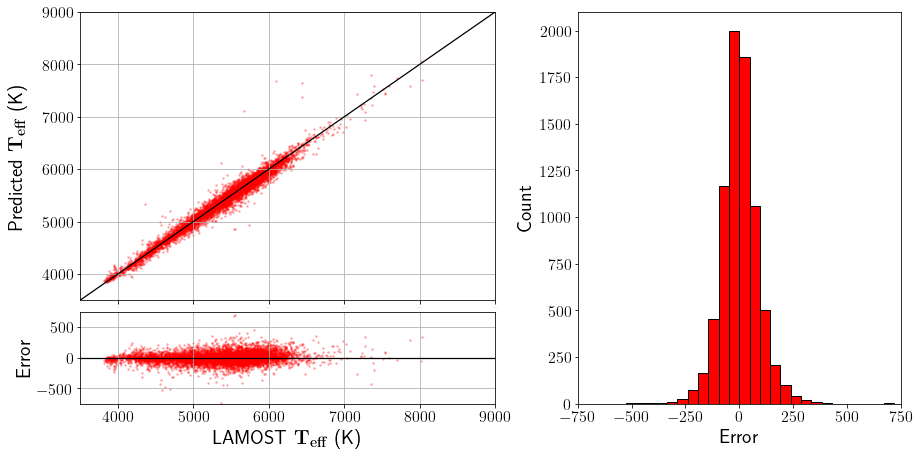

In [24]:
# Plot the prediction and error graphs and save them
teff_test_results = AP.plot_test_graphs(y_test_teff, teff_predictions_rf, r'$\mathbf{T_{eff}}$ (K)', 
                                        parameter_range = [3500, 9000], error_range = [-750, 750], color = 'red')
teff_test_results.savefig('rf_teff_estimator/test_results.jpg', dpi = 250)

# logg predictor

### Model Ranking
We first check the results from the hyperparameter optimization

In [6]:
# Print the final ranking of models
logg_models[['n_features', 'max_features', 'n_trees', 'min_samples_leaf', 'R2', 'StdR2']].sort_values(by = 'R2', ascending = False).head(5)

,n_features,max_features,n_trees,min_samples_leaf,R2,StdR2
8,45,0.25,100,1,0.809567,0.011994
9,45,0.5,100,1,0.809466,0.004705
57,15,0.5,100,1,0.808707,0.012288
25,60,0.5,100,1,0.807984,0.010707
24,60,0.25,100,1,0.807321,0.008262


### Model Training
Here, we choose the best hyperparameter combination (n_features = 45, max_features = 0.5, n_trees = 100 and msl = 1) and train a model using that

In [29]:
# Split the full sample into training and test samples
x_train, x_test, y_train, y_test = train_test_split(stars, stellar_parameters, test_size=0.25, random_state=42)

# Get the surface gravities
y_train_logg = y_train['logg']
y_test_logg = y_test['logg']

# Initialize the optimized feature selector
feature_selector = RFE(estimator=DecisionTreeRegressor(), 
                      n_features_to_select = 45, 
                      verbose = 0, step = 200)

# Initialize the optimized random forest
rf = RandomForestRegressor(n_estimators=100,
                           max_features=0.5,
                           min_samples_leaf = 1)

# Create a pipeline with the feature selector and the random forest
rf_logg_pipeline = Pipeline(steps = [('Feature Selector', feature_selector),('Model', rf)])

# Fit the pipeline to the training data
rf_logg_pipeline = rf_logg_pipeline.fit(x_train, y_train_logg.values.reshape(len(y_train_logg)))

# Save the pipeline to a file
jb.dump(rf_logg_pipeline, open('rf_logg_estimator/pipeline.sav', 'wb'), compress = 9)

### Model Testing
Having trained the model, the next step is to test it

In [30]:
# Split the full sample into training and test samples
x_train, x_test, y_train, y_test = train_test_split(stars, stellar_parameters, test_size=0.25, random_state=42)

# Load the pipeline from its file
rf_logg_pipeline = jb.load(open('rf_logg_estimator/pipeline.sav', 'rb'))

# Predict the gravities for the test sample
logg_predictions = rf_logg_pipeline.predict(x_test)

# Calculate the error metrics and print them to the screen
MAE = mean_absolute_error(y_test_logg, logg_predictions)
RMSE = np.sqrt(mean_squared_error(y_test_logg, logg_predictions))
MaxE = max_error(y_test_logg, logg_predictions)
R2 = r2_score(y_test_logg, logg_predictions)

print('Mean Absolute Error: {:.3f}'.format(MAE))
print('Root Mean Squared Error: {:.3f}'.format(RMSE))
print('Max Error: {:.3f}'.format(MaxE))
print('R2 Score: {:.3f}'.format(R2))

Mean Absolute Error: 0.131
Root Mean Squared Error: 0.208
Max Error: 2.550
R2 Score: 0.819


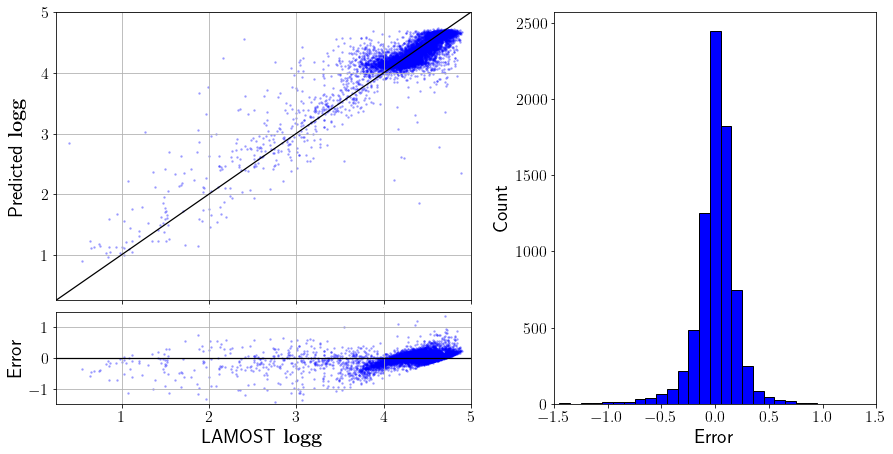

In [31]:
# Plot the prediction and error graphs and save them
logg_test_results = AP.plot_test_graphs(y_test_logg, logg_predictions, r'$\mathbf{logg}$',
                                        parameter_range = [0.25, 5.0], error_range = [-1.5, 1.5], color = 'blue')
logg_test_results.savefig('rf_logg_estimator/test_results.jpg', dpi = 250)

# FeH predictor

### Model Ranking
We first check the results from the hyperpameter optimization

In [32]:
feh_models[['n_features', 'max_features', 'n_trees', 'min_samples_leaf', 'R2', 'StdR2']].sort_values(by = 'R2', ascending = False).head(5)

,n_features,max_features,n_trees,min_samples_leaf,R2,StdR2
40,60,0.25,100,1,0.833125,0.003389
24,45,0.25,100,1,0.832983,0.003686
25,45,0.5,100,1,0.831773,0.004076
41,60,0.5,100,1,0.831268,0.005723
16,45,0.25,50,1,0.830448,0.006489


### Model Training
We then choose the best hyperparameter combination (n_features = 60, max_features = 0.25 and n_trees = 100) and train a model using that

In [34]:
# Split the full sample into training and test samples
x_train, x_test, y_train, y_test = train_test_split(stars, stellar_parameters, test_size=0.25, random_state=42)

# Get the metalicities
y_train_feh = y_train['feh']
y_test_feh = y_test['feh']

# Initialize the optimized feature selector
feature_selector = RFE(estimator=DecisionTreeRegressor(), 
                      n_features_to_select = 45, 
                      verbose = 0, step = 200)

# Initialize the optimized random forest
rf = RandomForestRegressor(n_estimators=100,
                           max_features=0.25)

# Create a pipeline with the feature selector and the random forest
rf_feh_pipeline = Pipeline(steps = [('Feature Selector', feature_selector),('Model', rf)])

# Fit the pipeline to the training data
rf_feh_pipeline = rf_feh_pipeline.fit(x_train, y_train_feh.values.reshape(len(y_train_feh)))

# Save the pipeline to a file
jb.dump(rf_feh_pipeline, open('rf_feh_estimator/pipeline.sav', 'wb'), compress = 9)

### Model Testing
Having trained the model, the next step is to test it

In [35]:
# Split the full sample into training and test samples
x_train, x_test, y_train, y_test = train_test_split(stars, stellar_parameters, test_size=0.25, random_state=42)

# Load the pipeline from its file
rf_feh_pipeline = jb.load(open('rf_feh_estimator/pipeline.sav', 'rb'))

# Predict the metalicities for the test sample
feh_predictions_rf = rf_feh_pipeline.predict(x_test)

# Calculate the error metrics and print them to the screen
MAE = mean_absolute_error(y_test_feh, feh_predictions_rf)
RMSE = np.sqrt(mean_squared_error(y_test_feh, feh_predictions_rf))
MaxE = max_error(y_test_feh, feh_predictions_rf)
R2 = r2_score(y_test_feh, feh_predictions_rf)

print('Mean Absolute Error: {:.3f}'.format(MAE))
print('Root Mean Squared Error: {:.3f}'.format(RMSE))
print('Max Error: {:.3f}'.format(MaxE))
print('R2 Score: {:.3f}'.format(R2))

Mean Absolute Error: 0.115
Root Mean Squared Error: 0.158
Max Error: 1.334
R2 Score: 0.834


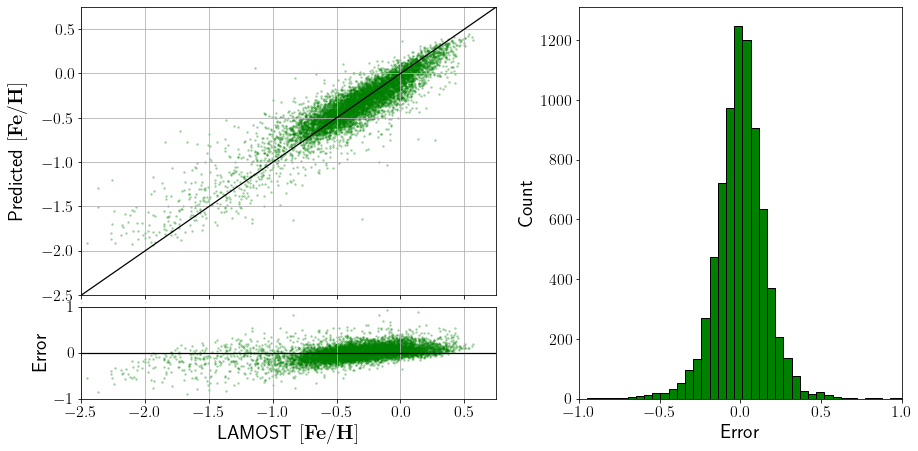

In [37]:
# Plot the prediction and error graphs and save them
feh_test_results = AP.plot_test_graphs(y_test_feh, feh_predictions_rf, r'$\mathbf{[Fe/H]}$',
                                        parameter_range = [-2.5, 0.75], error_range = [-1.0, 1.0], color = 'green')
feh_test_results.savefig('rf_feh_estimator/test_results.jpg', dpi = 250)